In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.20.0


In [2]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EAFQG74CK to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: aml-eastus2-2021
Azure region: eastus2
Subscription id: 1fb3620c-78c6-4fdc-b700-e4238cb192e6
Resource group: rg_aml


In [4]:
from azureml.core import Datastore
datastore = Datastore.register_azure_blob_container(workspace = ws, 
                                        datastore_name = 'img_ds',
                                        container_name = 'source-data',
                                        account_name = 'amlpocwestus6466069240',
                                        sas_token = '?sv=2019-12-12&ss=b&srt=co&sp=rlx&se=2021-03-31T15:28:38Z&st=2021-02-02T07:28:38Z&spr=https&sig=3KyJdypHKf%2FxktopuYLAbzy6YszG3LTpMUKHD5Qkn3I%3D',
                                        overwrite=False
                                        )
print(datastore)

{
  "name": "img_ds",
  "container_name": "source-data",
  "account_name": "amlpocwestus6466069240",
  "protocol": "https",
  "endpoint": "core.windows.net"
}


In [5]:
from azureml.core import Dataset
datastore_paths = [(datastore, 'anji_data')]
dataset = Dataset.File.from_files(path=datastore_paths)

In [6]:
from azureml.core import Experiment

experiment_name = 'exp-yolov3-sample'
experiment = Experiment(ws, name=experiment_name)

In [7]:
from azureml.core import Environment

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', 
                                                file_path = './conda_dependencies.yml'
                                                )

In [8]:
from azureml.core import ScriptRunConfig

project_folder = '.'

src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=['--epochs', 6,'--data-folder', dataset.as_mount('/tmp/tmp_imgdata')],
                      environment=pytorch_env)

In [9]:
run = experiment.submit(src,tags={"purpose":"AML yolov3 sample"})
print(run)

Run(Experiment: exp-yolov3-sample,
Id: exp-yolov3-sample_1612256245_8b128f5d,
Type: azureml.scriptrun,
Status: Preparing)


In [10]:
run.wait_for_completion(show_output=True)

RunId: exp-yolov3-sample_1612256245_8b128f5d
Web View: https://ml.azure.com/experiments/exp-yolov3-sample/runs/exp-yolov3-sample_1612256245_8b128f5d?wsid=/subscriptions/1fb3620c-78c6-4fdc-b700-e4238cb192e6/resourcegroups/rg_aml/workspaces/aml-eastus2-2021

Streaming azureml-logs/60_control_log.txt

[2021-02-02T08:57:43.456006] Entering context manager injector.
[2021-02-02T08:57:44.219460] Using urllib.request Python 3.0 or later
Streaming log file azureml-logs/60_control_log.txt
Running: ['/bin/bash', '/tmp/azureml_runs/exp-yolov3-sample_1612256245_8b128f5d/azureml-environment-setup/conda_env_checker.sh']
Starting the daemon thread to refresh tokens in background for process with pid = 5863
Materialized conda environment not found on target: /home/azureuser/.azureml/envs/azureml_3920396d68489eb8cba06b51559acad7


[2021-02-02T08:57:44.332219] Logging experiment preparation status in history service.
Running: ['/bin/bash', '/tmp/azureml_runs/exp-yolov3-sample_1612256245_8b128f5d/azureml

{'runId': 'exp-yolov3-sample_1612256245_8b128f5d',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-02-02T09:00:33.354558Z',
 'endTimeUtc': '2021-02-02T09:38:28.939541Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '55881e92-d631-49a4-b1a0-2cd221c22a8e'},
 'inputDatasets': [{'dataset': {'id': '76500dab-ab57-4b8c-848d-8045fd448122'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__289cdbc3', 'mechanism': 'Mount', 'pathOnCompute': '/tmp/tmp_imgdata'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--epochs',
   '6',
   '--data-folder',
   'DatasetConsumptionConfig:input__289cdbc3'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {'input__289cdbc3': {'dataLocation': {'dataset': {'id': '76500dab-ab57-4b8c-848d-8045fd448122',
      'name': None,
     

In [11]:
assert(run.get_status() == "Completed")

In [12]:
print(run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/70_driver_log.txt', 'logs/azureml/7285_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'outputs/best.pt', 'outputs/last.pt']


In [13]:
# Register Model
model = run.register_model(model_name = 'yolov3-sample-model', model_path = 'outputs/best.pt')
print(model.name, model.id, model.version, sep = '\t')

yolov3-sample-model	yolov3-sample-model:1	1


In [23]:
# Deploy Model
from azureml.core import Environment
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

#model = Model(ws, 'yolov3-sample-model')

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './conda_dependencies.yml')
dockerfile = """
FROM mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04
RUN apt update
RUN apt-get -y install sudo
RUN sudo apt -y install libgl1-mesa-glx
"""
pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = None
pytorch_env.docker.base_dockerfile = dockerfile
pytorch_env.inferencing_stack_version = 'latest'

inference_config = InferenceConfig(
        entry_script="score.py", 
        environment=pytorch_env,
        source_directory = "./"
        )

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=2, 
                                               tags={'framework':'pytorch'},
                                               description='ACI with Yolov3')

service = Model.deploy(workspace=ws, 
                           name='aci-yolov3-sample', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [24]:
service.get_logs()

'2021-02-02T10:32:51,546258151+00:00 - iot-server/run \n2021-02-02T10:32:51,547139971+00:00 - gunicorn/run \n2021-02-02T10:32:51,547176972+00:00 - rsyslog/run \n2021-02-02T10:32:51,558492834+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-02-02T10:32:51,671150243+00:00 - iot-server/finish 1 0\n2021-02-02T10:32:51,672769681+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (14)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 42\nSPARK_HOME not set. Skipping PySpark Initialization.\nGenerating new fontManager, this may take some time...\nInitializing logger\n2021-02-02 10:32:54,292 | root | INFO | Starting up app insights client\n2021-02-02 10:32:54,292 | root | INFO | Starting up request id generator\n2021-02-02 10:32:54,293 | root | INFO | Starting up app insight hooks\n2021-02-02 10:32:54,293 | root | INFO | Invoking user\'s init func

In [25]:
print(service.scoring_uri)

http://a1261ecd-5dff-4254-a776-288e11bdff73.eastus2.azurecontainer.io/score


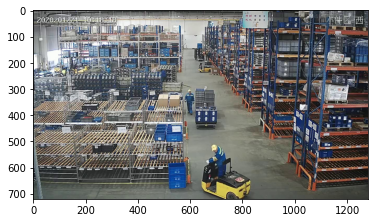

In [26]:
import json
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(Image.open('testfiles/test-image-2.jpg'))

In [27]:
import requests
from base64 import b64encode
# send a random row from the test set to score
with open('testfiles/test-image-2.jpg', 'rb') as jpg_file:
    byte_content = jpg_file.read()
    jpg_file.close()
base64_bytes = b64encode(byte_content)
base64_string = base64_bytes.decode()

input_data=json.dumps({'data': base64_string})

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

max_len = len(resp.text) -1
result = resp.text[1:max_len].replace("\\","")

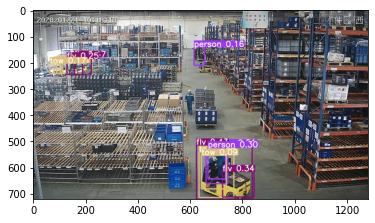

In [28]:
import base64

result_image = json.loads(result)["result_image"]

image_data = base64.b64decode(result_image)

with open('testfiles/test-impage-2-detection.jpg', 'wb') as jpg_file:
    jpg_file.write(image_data)

%matplotlib inline
plt.imshow(Image.open('testfiles/test-impage-2-detection.jpg'))

In [ ]:
# 删除ACI
service.delete()

In [ ]:
# 删除data store
datastore.unregister()
